## Problème de prédiction du type de cancer de la peau : distinction entre tumeurs bénignes et malignes à l’aide de modèles d’apprentissage profond

Dans le Lab 1, nous avons appris à utiliser un Multi-Layer Perceptron, et les algorithmes de l'apprentissage automatiques pour construire un modèle de classification capable de distinguer les tumeurs bénignes des tumeurs malignes.

Aujourd'hui, nous allons explorer l'utilisation des couches de convolution en 1D.

Pour cela, nous allons utiliser la bibliothèque Keras, en particulier la couche Conv1D, afin de résoudre ce problème de classification. Il nous faudra simplement effectuer une petite modification des dimensions de nos données pour pouvoir appliquer cette opération correctement.

C'est parti !


#### Importer les bibliothèque essentielles

In [1]:
! pip install pandas
! pip install xgboost
! pip install scikit-learn
! pip install opencv-python
! pip install tensorflow
! pip install --upgrade keras
! pip install pydot

In [2]:
from pathlib import Path
from  glob import glob
import os
import cv2
import numpy as  np
import pandas as pd
import copy
import xgboost as xgb
import time
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [31]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import plot_model

#### Définition d'une classe pour charger les données

In [5]:

class CustomDataset:
    def __init__(self, proportion: float, root: Path, train: bool, size : tuple):
        """
        Initialisation de l'objet CustomDataset avec la proportion des données à utiliser
        et le répertoire racine contenant les images.

        :param proportion: Proportion des données à charger (0 à 1).
        :param root: Répertoire racine où se trouvent les images.
        """
        self.proportion = proportion
        self.root = root
        self.data = {"Features": [], "Target": []}
        self.target = ["benign", "malignant"]
       
        self.dataType = "train" if train else "test" 

        self.size =  size

    def dataloader(self):
        """
        Charge et traite les images depuis les répertoires 'benign' et 'malignant', 
        en appliquant une proportion des données spécifiée.

        :return: Tuple contenant les caractéristiques (Features) et les cibles (Target) des données.
        """
        # Chargement des images et valeurs cibles benign et malignant
        for item in self.target:
            
            files = glob(os.path.join(self.root, f"{self.dataType}/{item}/*.jpg"))
            num_files = int(len(files) * self.proportion)

            self.data["Features"].extend([cv2.resize(cv2.imread(imagePath), self.size).flatten().astype(np.float32) for imagePath in files[:num_files]])
            self.data["Target"].extend([item for _ in range(num_files)])
   
        return self.data["Features"], self.data["Target"]


### Charger les données disponibles dans un dossier dont vous connaissez le chemin

##### Définir le chemin vers le dossier contenant les données

In [6]:
root = "/home/laris/laris/cours/CV50/inputs/raw/data/"

##### Définir la proportion des données à charger

In [7]:
proportion = 0.3

In [8]:
datasets = CustomDataset(proportion=proportion, root = root, train=True, size=(224,224))

In [9]:
features , target = datasets.dataloader()

In [10]:
train = pd.DataFrame(data={"features": features, "target": target})

In [11]:
train

,features,target
0,"[162.0, 158.0, 223.0, 161.0, 160.0, 222.0, 168...",benign
1,"[161.0, 154.0, 229.0, 166.0, 159.0, 232.0, 169...",benign
2,"[164.0, 149.0, 241.0, 160.0, 147.0, 239.0, 164...",benign
3,"[60.0, 79.0, 112.0, 68.0, 83.0, 115.0, 71.0, 8...",benign
4,"[112.0, 126.0, 154.0, 113.0, 124.0, 154.0, 111...",benign
...,...,...
786,"[105.0, 95.0, 125.0, 100.0, 93.0, 120.0, 102.0...",malignant
787,"[0.0, 0.0, 10.0, 0.0, 0.0, 24.0, 43.0, 55.0, 1...",malignant
788,"[81.0, 95.0, 153.0, 111.0, 127.0, 186.0, 128.0...",malignant
789,"[154.0, 146.0, 183.0, 145.0, 143.0, 185.0, 142...",malignant


In [12]:
Train = pd.DataFrame(train['features'].tolist(), columns=[f'feature_{i+1}' for i in range(len(train['features'][0]))])

In [13]:
Train

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_150519,feature_150520,feature_150521,feature_150522,feature_150523,feature_150524,feature_150525,feature_150526,feature_150527,feature_150528
0,162.0,158.0,223.0,161.0,160.0,222.0,168.0,161.0,222.0,171.0,...,200.0,132.0,140.0,199.0,130.0,141.0,198.0,132.0,144.0,202.0
1,161.0,154.0,229.0,166.0,159.0,232.0,169.0,162.0,237.0,167.0,...,218.0,158.0,153.0,222.0,158.0,153.0,222.0,157.0,152.0,214.0
2,164.0,149.0,241.0,160.0,147.0,239.0,164.0,146.0,239.0,164.0,...,221.0,145.0,137.0,220.0,143.0,135.0,218.0,138.0,132.0,214.0
3,60.0,79.0,112.0,68.0,83.0,115.0,71.0,86.0,118.0,69.0,...,155.0,125.0,132.0,157.0,120.0,127.0,154.0,118.0,124.0,153.0
4,112.0,126.0,154.0,113.0,124.0,154.0,111.0,125.0,154.0,107.0,...,153.0,111.0,122.0,150.0,104.0,118.0,146.0,100.0,114.0,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,105.0,95.0,125.0,100.0,93.0,120.0,102.0,93.0,120.0,110.0,...,155.0,146.0,134.0,152.0,144.0,132.0,152.0,145.0,133.0,153.0
787,0.0,0.0,10.0,0.0,0.0,24.0,43.0,55.0,109.0,67.0,...,183.0,97.0,118.0,186.0,100.0,119.0,186.0,90.0,109.0,176.0
788,81.0,95.0,153.0,111.0,127.0,186.0,128.0,144.0,211.0,123.0,...,202.0,111.0,130.0,197.0,116.0,134.0,199.0,104.0,122.0,187.0
789,154.0,146.0,183.0,145.0,143.0,185.0,142.0,141.0,181.0,158.0,...,181.0,166.0,151.0,182.0,181.0,152.0,185.0,162.0,147.0,179.0


#### Encoder la variable cible sous forme d'entier pour pouvoir faire l'entraînement

Exemple:

    benign -----> 0
    malignant ----> 1

In [14]:
# Encoder les valeurs cibles sous forme d'entier.
encoder = preprocessing.LabelEncoder() 

encoder.fit(train["target"]) 
 
train["target"]= encoder.transform(train["target"]) 

#### Convertir en matrice de données

In [15]:
X_Train = Train.values
Y_Train = train["target"].values

#### À l'aide de sklearn, écrivez une fonction pour diviser les données en ensemble d'apprentissage et de validation

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_Train, Y_Train, test_size=0.25, shuffle=True, random_state=42)

### Caractéristique de nos données actuelles

In [19]:
print("----------------------------------")
print(x_train.shape)
print("-----------------------------------")
print(x_train[0].shape)
print("-----------------------------------")
print(x_train[0])

----------------------------------
(593, 150528)
-----------------------------------
(150528,)
-----------------------------------
[145. 155. 239. ... 127. 146. 214.]


Nous disposons de données en une seule dimension :

[nombre de caractéristiques]

Cependant, lorsque nous nous intéressons au nombre d'exemples dans notre jeu de données, nous devons passer à une représentation en deux dimensions :

[nombre d'exemples, nombre de caractéristiques]

#### Conv1D

Pour appliquer la couche de convolution Conv1D, il est nécessaire d'ajouter une dimension supplémentaire à nos données.

Cela permet de prendre en compte l'aspect temporel ou séquentiel des données, en indiquant combien de valeurs sont disponibles à chaque étape de la séquence.

La forme des données doit donc être structurée comme suit :

[nombre d'exemples, time_steps, nombre de caractéristiques]

In [22]:
sample_size = x_train.shape[0] # nombre d'exemples dans l'ensemble d'entraînement
time_steps  = x_train.shape[1] # le temps
input_dimension = 1               # nombre d'exemples par unité de temps

#### Transformermation de l'ensemble d'entraînement

In [23]:
x_train_reshaped = x_train.reshape(sample_size,time_steps,input_dimension)

### Après transformation

In [25]:
print("----------------------------------")
print(x_train_reshaped.shape)
print("-----------------------------------")
print(x_train_reshaped[0].shape)
print("-----------------------------------")
print(x_train_reshaped[0])

----------------------------------
(593, 150528, 1)
-----------------------------------
(150528, 1)
-----------------------------------
[[145.]
 [155.]
 [239.]
 ...
 [127.]
 [146.]
 [214.]]


#### Transformermation de l'ensemble de test

In [26]:
sample_size = x_test.shape[0] # nombre d'exemples dans l'ensemble d'entraînement
time_steps  = x_test.shape[1] # le temps
input_dimension = 1               # nombre d'exemples par unité de temps

In [27]:
x_test_reshaped = x_test.reshape(sample_size,time_steps,input_dimension)

### Après transformation

In [28]:
print("----------------------------------")
print(x_test_reshaped.shape)
print("-----------------------------------")
print(x_test_reshaped[0].shape)
print("-----------------------------------")
print(x_test_reshaped[0])

----------------------------------
(198, 150528, 1)
-----------------------------------
(150528, 1)
-----------------------------------
[[174.]
 [155.]
 [236.]
 ...
 [152.]
 [146.]
 [211.]]


## Création d'une architecture de type MLP en utilisant les couches conv1D

Nous utiliserons un modèle séquentiel avec trois couches cachées densément connectées et une couche de sortie dont la fonction d'activation est la fonction sigmoïde

#### Conv1D de keras 

Conv1D(filters=1, kernel_size=3, activation='relu')

<img src="https://controlandlearning.wordpress.com/wp-content/uploads/2020/07/figure-1.png" alt="description de l'image" width="500" height="300">


#### La fonction d'activation de la couche de sortie
Comme notre problème est un problème de classification binaire, nous voulons que la sortie du neuronne produise une probabilité dans l'intervalle [0, 1]. Pour cela nous allons utilser la **fonction sigmoïde** utiliser dans les modèles de régression logistique.


$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

<img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LastLayer.png?hl=fr" alt="description de l'image" width="700" height="300">


In [32]:
activationF= 'sigmoid'

#### Définir la fenêtre temporelle ainsi que le nombre d'exemples correspondant à une échelle de temps.

In [33]:
# fenêtre temporelle
n_timesteps = x_train_reshaped.shape[1]

#nombre d'exemples correspondant à une échelle de temps
n_features =  x_train_reshaped.shape[2]

#### Faire l'architecture du modèle

In [48]:
# Créer un modèle séquentiel
model = Sequential(name="model_beta") 

# Ajouter la couche d'entrée avec la forme des données (nombre de pas de temps, nombre de caractéristiques)
model.add(Input(shape=(n_timesteps, n_features)))

# Ajouter la première couche de convolution 1D avec 8 filtres, un noyau de taille 6 et une activation ELU
model.add(Conv1D(filters=16, kernel_size=7, activation='elu', name="Conv1D_1"))

# Ajouter une couche de dropout pour éviter le surapprentissage, avec un taux de 50%
model.add(Dropout(0.5))

# Ajouter la deuxième couche de convolution 1D avec 32 filtres, un noyau de taille 3 et une activation ELU
model.add(Conv1D(filters=8, kernel_size=3, activation='elu', name="Conv1D_2"))

# Ajouter une couche de max pooling pour réduire la dimensionnalité, avec une taille de pool de 2
model.add(MaxPooling1D(pool_size=4, name="MaxPooling1D"))

# Applatir les matrices de données issues des convolutions pour les préparer à la couche dense suivante
model.add(Flatten())

# Ajouter une couche dense avec 32 neurones et une activation ELU
model.add(Dense(32, activation='elu', name="Dense_1"))

# Ajouter une couche dense finale avec un neurone pour la sortie (activation définie par 'activationF')
model.add(Dense(1, activation=activationF, name="Dense_2"))


#### Sommaire des différentes couches de votre modèle

In [49]:
model.summary()

Model: "model_beta"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 150522, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150522, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 150520, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D (MaxPooling1D)     │ (None, 37630, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 301040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │     9,633,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,633,865 (36.75 MB)

 Trainable params: 9,633,865 (36.75 MB)

 Non-trainable params: 0 (0.00 B)

#### Afficher le schéma associé  à votre modèle

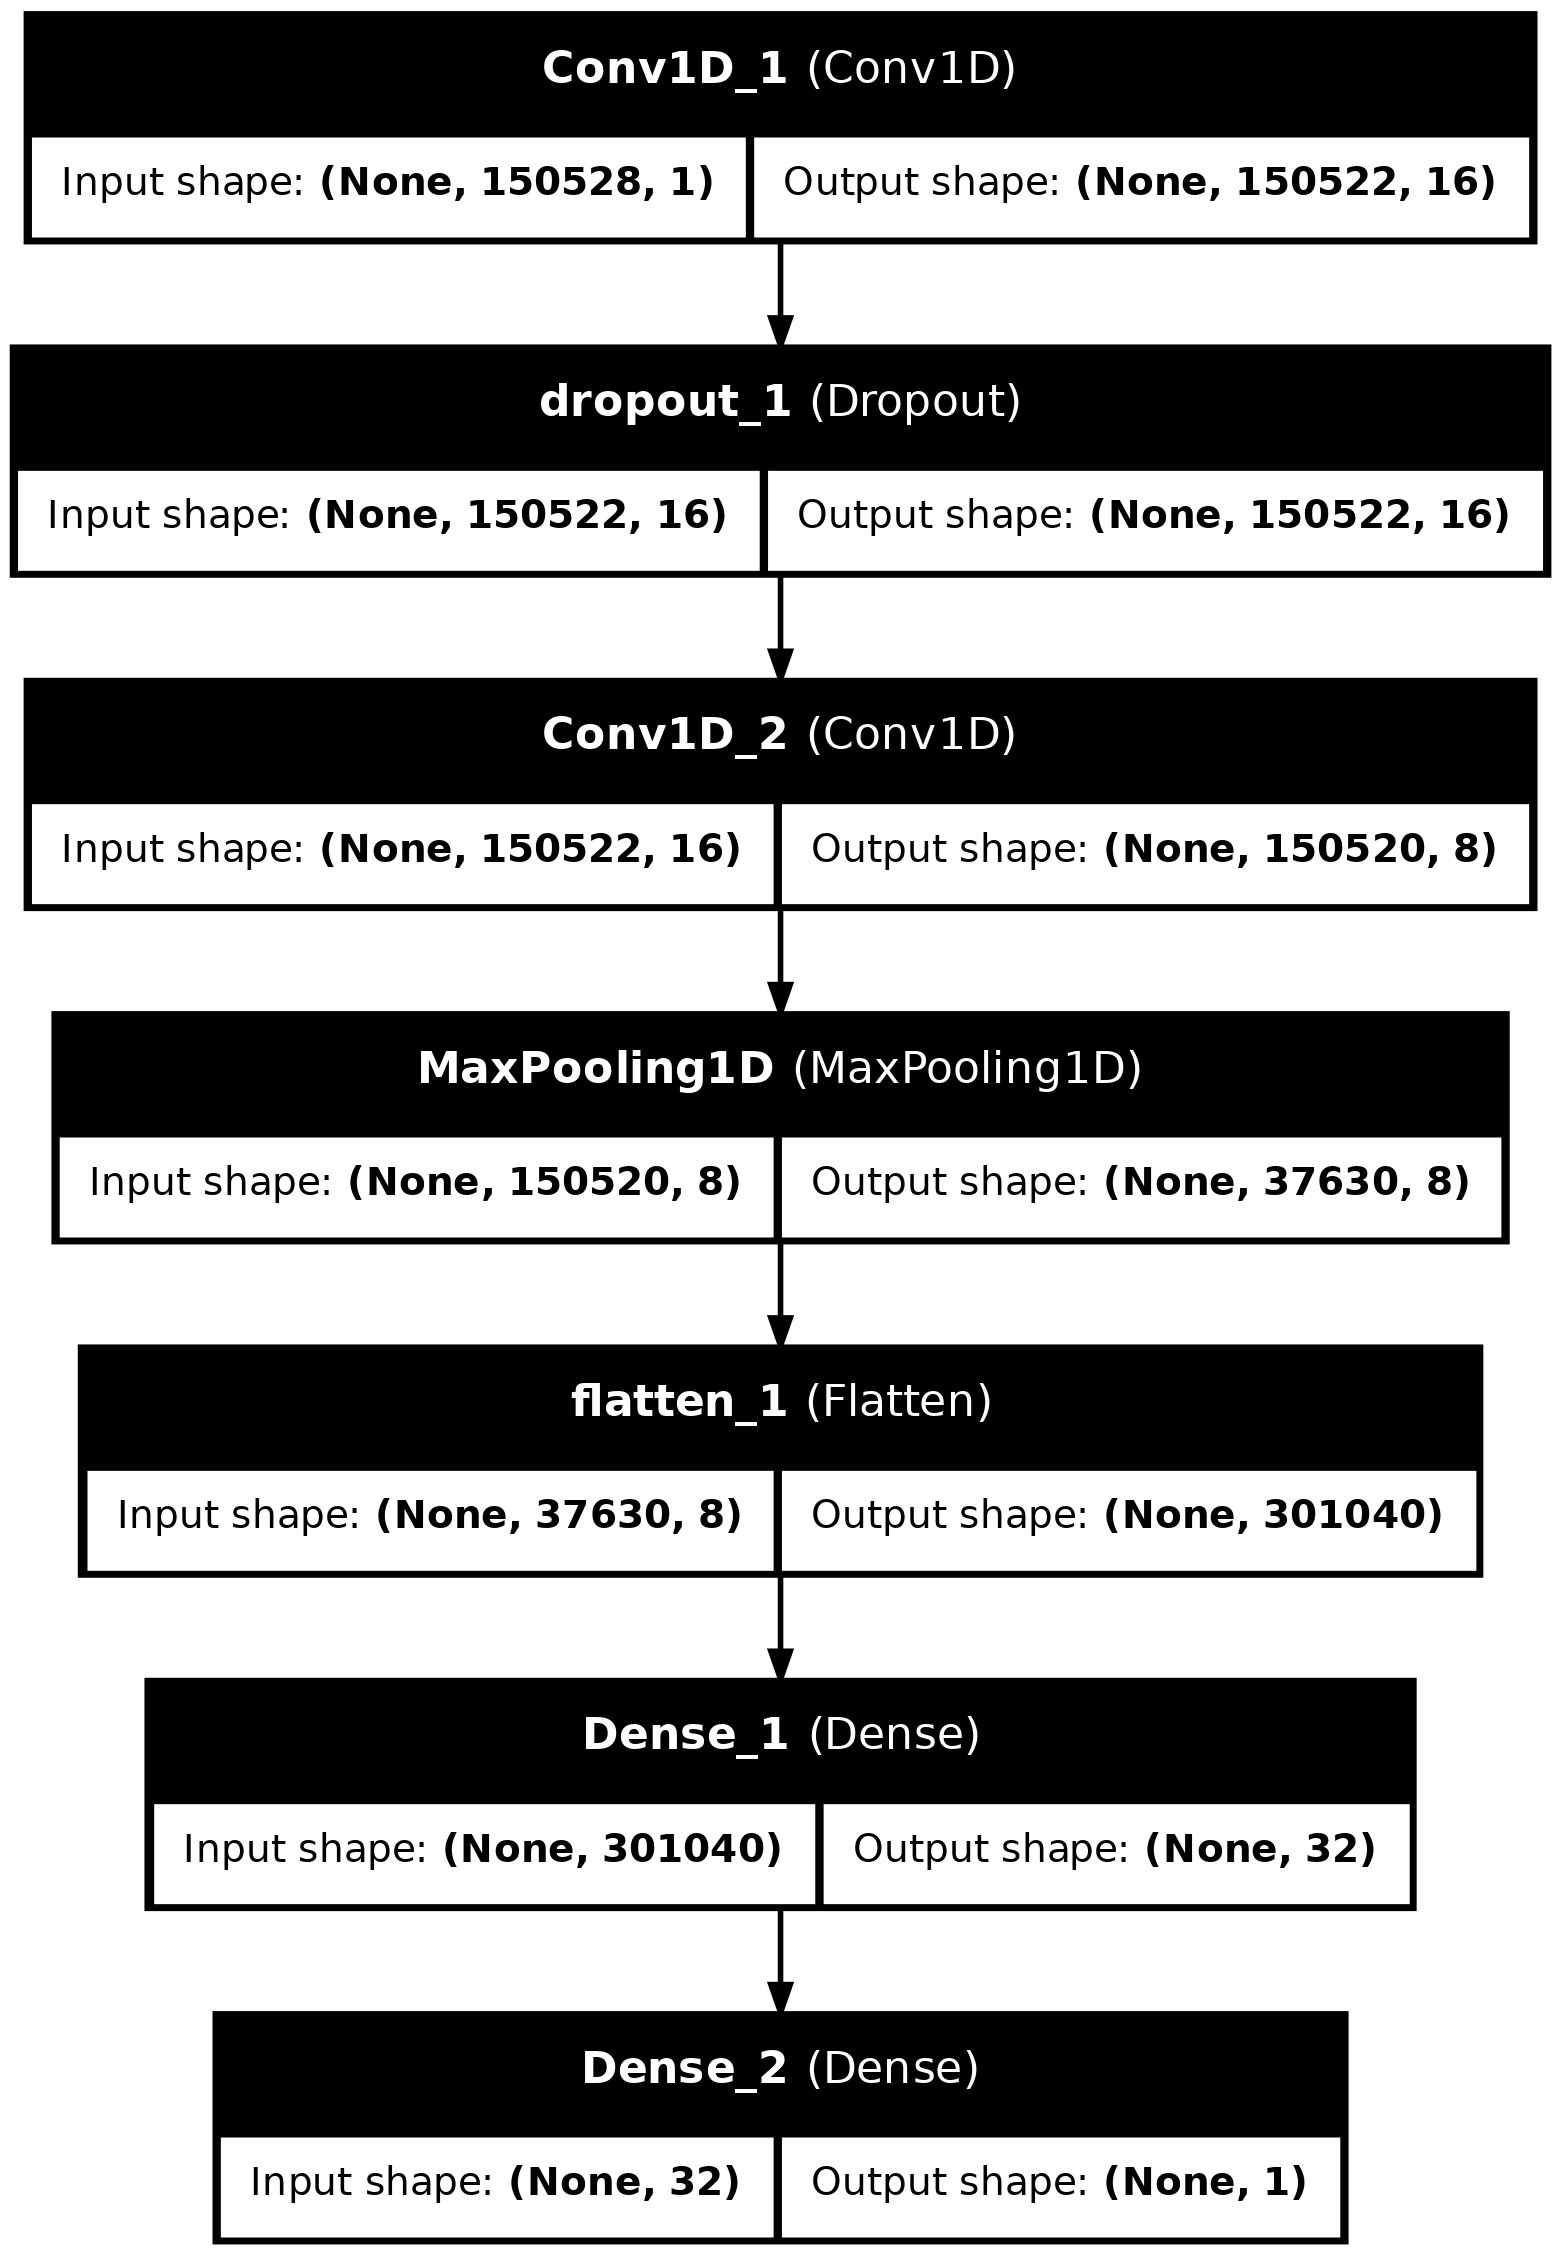

In [50]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

#### Définition de la fonction coût - Binary Cross-Entropy

La **Binary Cross-Entropy** est utilisée pour les problèmes de classification binaire, où l'on cherche à prédire si une instance appartient à la classe 0 ou à la classe 1. Elle mesure la différence entre les prédictions du modèle et les vraies étiquettes.

La fonction coût est définie comme suit :

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$



In [51]:
loss = 'binary_crossentropy'

#### Définir l'algorithme d'optimisation

In [52]:
optimizer = 'adam'

#### Définir la métrique d'évaluation

In [53]:
metrics = ['accuracy']

#### Compiler votre modèle

In [54]:
# Compiler le model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

### Définir le nombre d'époques et le nombre d'exemples à mettre dans l'algorithme

In [55]:
verbose = 1
epochs = 4
batch_size = 2

#### Entraîner le modèle

In [56]:
# Fit the model 
history = model.fit(x=x_train_reshaped, y=y_train, 
                              epochs=epochs, 
                              batch_size=batch_size, 
                              verbose=verbose,
                              validation_split=0.2,
                              shuffle=True)

Epoch 1/4
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5169 - loss: 1150.6505 - val_accuracy: 0.4874 - val_loss: 5.2992
Epoch 2/4
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5039 - loss: 19.1575 - val_accuracy: 0.4202 - val_loss: 6.1615
Epoch 3/4
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.4703 - loss: 0.6963 - val_accuracy: 0.7227 - val_loss: 5.9608
Epoch 4/4
237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5164 - loss: 0.6927 - val_accuracy: 0.7227 - val_loss: 5.9463


#### Fonction coût pour l'ensemble d'entraînement et de validation

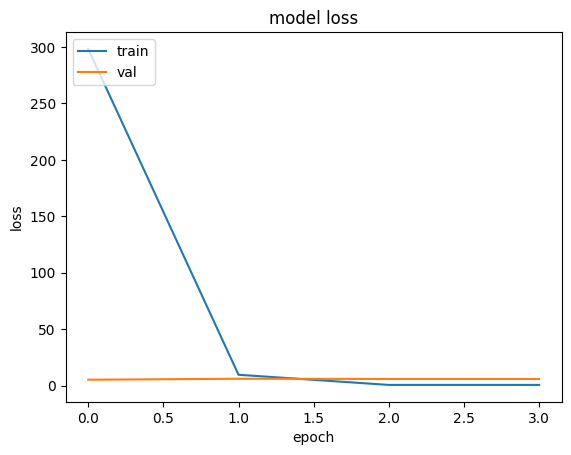

In [57]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Comparaison entre l'exactitude de l'ensemble d'entraînement et l'ensemble de validation

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.7226890921592712


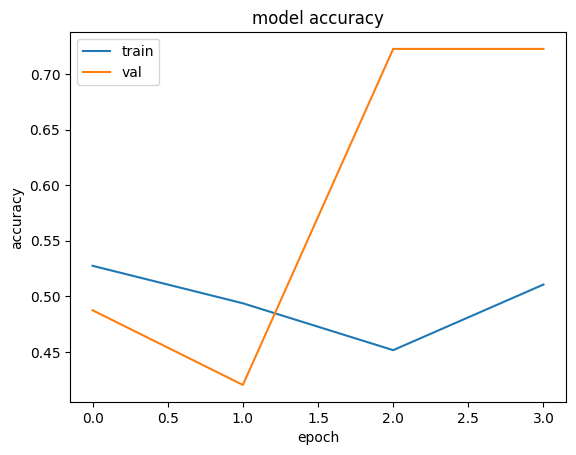

In [58]:

print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Évaluation du model sur les jeux de données de l'ensenble de test

In [59]:
# Assuming you have a trained model
loss, accuracy = model.evaluate(x=x_test_reshaped, y=y_test)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7529 - loss: 6.6437
Val Loss: 5.632826805114746
Val Accuracy: 0.7828282713890076


#### Continuer 

Modifiez les données pour que le nombre d'exemples à chaque pas de temps représente les pixels d'une image. Cela implique que chaque unité de temps correspond à une image entière (un ensemble de pixels) et non plus à une seule caractéristique de l'image.

In [ ]:
...